## Dataset

For this experiment, we use the Enron Email Dataset, a popular corpus for spam filtering research. This dataset contains a large collection of real emails from the Enron corporation, labeled as spam or ham (not spam). In total it has about 33,716 messages – roughly 17,171 spam emails and 16,545 ham emails. This balance is nearly 50/50, which is helpful (the classes are not extremely imbalanced, though some minor imbalance exists).

In [34]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization, Input, Embedding, Dense, Dropout, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from tensorflow.keras.optimizers import Adam
import time
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import StandardScaler
import plotly

In [4]:
dataset = pd.read_csv('data/enron_spam_data.csv', sep=",")

# Display the first few rows of the dataset
print(dataset.head())

# Display the shape of the dataset
print(dataset.shape)

   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14  
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14  
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14  
(33716, 5)


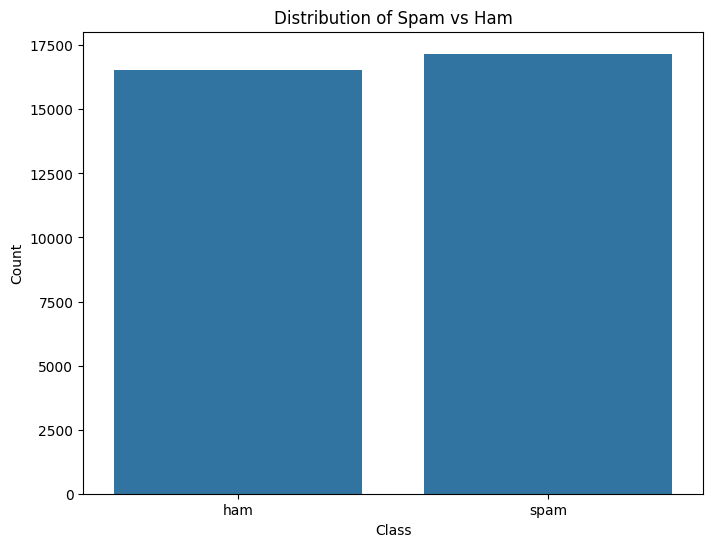

Spam/Ham
spam    17171
ham     16545
Name: count, dtype: int64

Percentages:
Spam/Ham
spam    50.928343
ham     49.071657
Name: proportion, dtype: float64


In [5]:
# Count plot to show class balance
plt.figure(figsize=(8, 6))
sns.countplot(data=dataset, x='Spam/Ham')
plt.title('Distribution of Spam vs Ham')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# summary statistics
print(dataset['Spam/Ham'].value_counts())
print("\nPercentages:")
print(dataset['Spam/Ham'].value_counts(normalize=True) * 100)


## ANALYZE DATA

In [6]:
# 1. Analyze column relevance and data types
print("="*60)
print("COLUMN ANALYSIS")
print("="*60)
print("\nDataset Info:")
print(dataset.info())

print("\n" + "="*60)
print("Column Analysis:")
print("="*60)

columns_analysis = {
    'Message ID': 'Unique identifier - NOT useful for prediction',
    'Subject': 'VERY USEFUL - Email subject contains important keywords',
    'Message': 'VERY USEFUL - Main email body, primary source of information',
    'Spam/Ham': 'TARGET variable',
    'Date': 'Time information - Could be useful but likely not critical'
}

for col, description in columns_analysis.items():
    print(f"\n{col:15s}: {description}")
    
# Use Subject + Message as features")

COLUMN ANALYSIS

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  33716 non-null  int64 
 1   Subject     33427 non-null  object
 2   Message     33345 non-null  object
 3   Spam/Ham    33716 non-null  object
 4   Date        33716 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None

Column Analysis:

Message ID     : Unique identifier - NOT useful for prediction

Subject        : VERY USEFUL - Email subject contains important keywords

Message        : VERY USEFUL - Main email body, primary source of information

Spam/Ham       : TARGET variable

Date           : Time information - Could be useful but likely not critical


In [7]:
# 2. Check for missing values
print("Missing Values Analysis:")
print("="*60)
missing_values = dataset.isnull().sum()
missing_percent = (missing_values / len(dataset)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Percentage': missing_percent.values
})

print(missing_df)

print("\n" + "="*60)
print(f"Total rows: {len(dataset)}")
print(f"Rows with missing Subject: {dataset['Subject'].isnull().sum()}")
print(f"Rows with missing Message: {dataset['Message'].isnull().sum()}")
print("="*60)


Missing Values Analysis:
       Column  Missing Count  Percentage
0  Message ID              0    0.000000
1     Subject            289    0.857160
2     Message            371    1.100368
3    Spam/Ham              0    0.000000
4        Date              0    0.000000

Total rows: 33716
Rows with missing Subject: 289
Rows with missing Message: 371


## Exploratory Data Analysis

In [8]:
# 3. Basic text statistics
print("TEXT CHARACTERISTICS ANALYSIS")
print("="*60)

# Fill NaN values with empty strings for analysis
dataset['Subject'] = dataset['Subject'].fillna('')
dataset['Message'] = dataset['Message'].fillna('')

# Calculate text lengths
dataset['subject_length'] = dataset['Subject'].str.len()
dataset['message_length'] = dataset['Message'].str.len()
dataset['total_length'] = dataset['subject_length'] + dataset['message_length']

# Word counts
dataset['subject_word_count'] = dataset['Subject'].str.split().str.len()
dataset['message_word_count'] = dataset['Message'].str.split().str.len()
dataset['total_word_count'] = dataset['subject_word_count'] + dataset['message_word_count']

# Analyze by spam/ham
print("\nLength Statistics by Class:")
print(dataset.groupby('Spam/Ham')[['subject_length', 'message_length', 
                                     'subject_word_count', 'message_word_count']].describe())


TEXT CHARACTERISTICS ANALYSIS

Length Statistics by Class:
         subject_length                                                       \
                  count       mean        std  min   25%   50%   75%     max   
Spam/Ham                                                                       
ham             16545.0  31.153823  26.288072  1.0  18.0  28.0  41.0  1355.0   
spam            17171.0  37.869955  53.649735  0.0  22.0  34.0  47.0  3153.0   

         message_length               ... subject_word_count         \
                  count         mean  ...                75%    max   
Spam/Ham                              ...                             
ham             16545.0  1676.289211  ...                8.0  278.0   
spam            17171.0  1271.866053  ...               10.0  602.0   

         message_word_count                                                    \
                      count        mean          std  min   25%    50%    75%   
Spam/Ham              

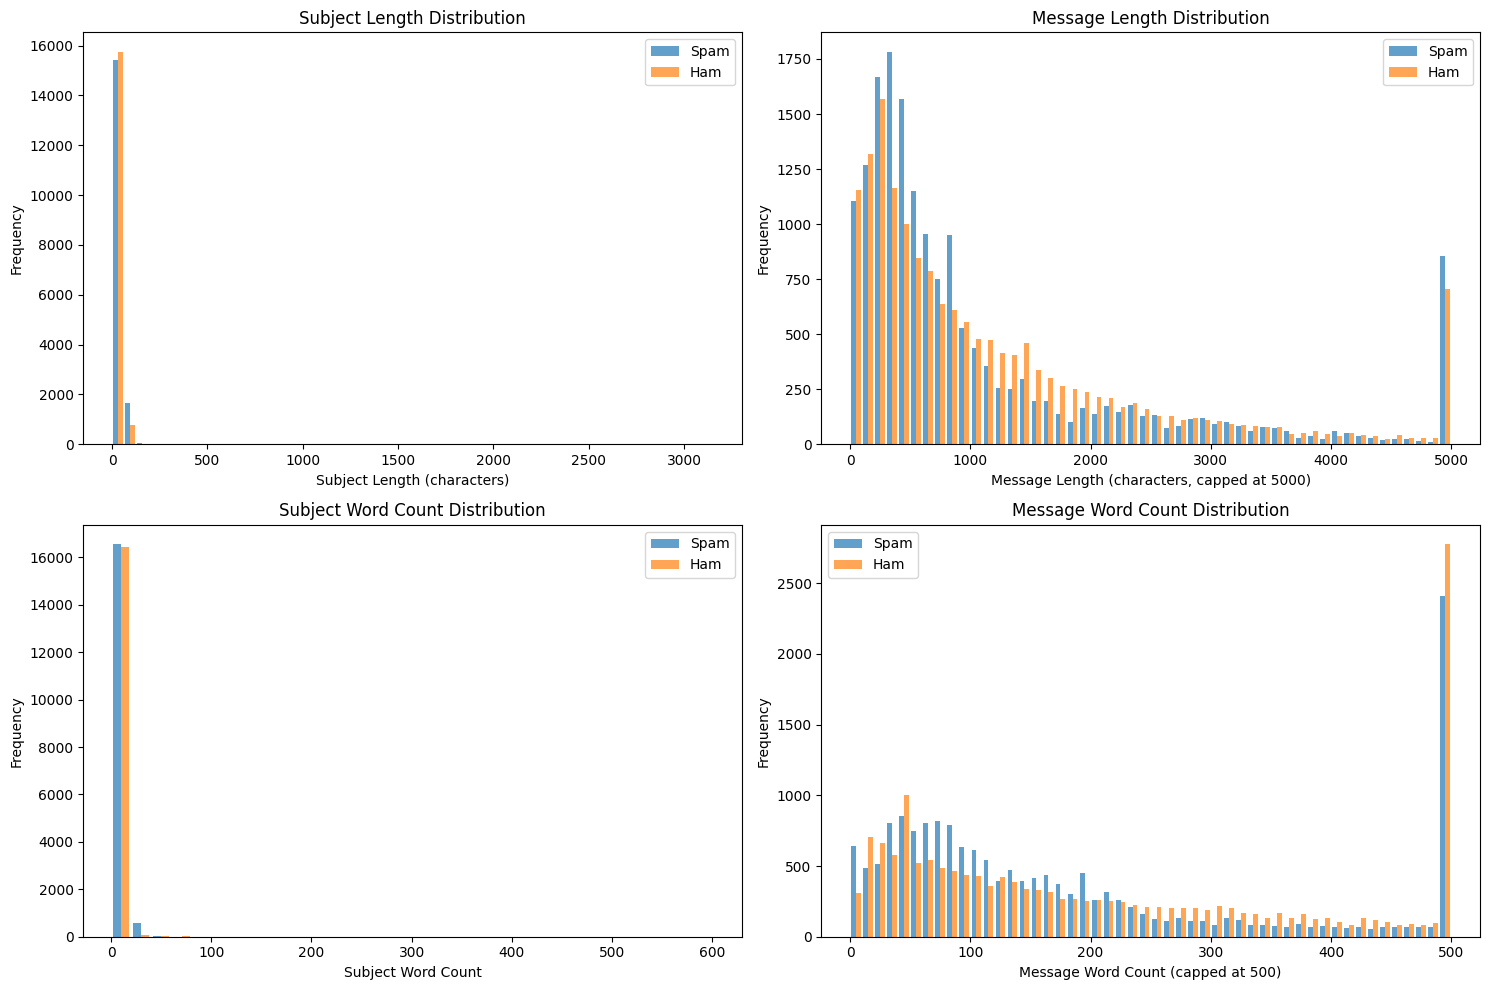


Key Observations:
- Spam and Ham emails have different length characteristics
- These features could be useful for classification


In [9]:
# 4. Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Subject length distribution
axes[0, 0].hist([dataset[dataset['Spam/Ham']=='spam']['subject_length'],
                 dataset[dataset['Spam/Ham']=='ham']['subject_length']], 
                bins=50, label=['Spam', 'Ham'], alpha=0.7)
axes[0, 0].set_xlabel('Subject Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Subject Length Distribution')
axes[0, 0].legend()

# Message length distribution (capped at 5000 for visibility)
spam_msg_len = dataset[dataset['Spam/Ham']=='spam']['message_length'].clip(upper=5000)
ham_msg_len = dataset[dataset['Spam/Ham']=='ham']['message_length'].clip(upper=5000)
axes[0, 1].hist([spam_msg_len, ham_msg_len], 
                bins=50, label=['Spam', 'Ham'], alpha=0.7)
axes[0, 1].set_xlabel('Message Length (characters, capped at 5000)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Message Length Distribution')
axes[0, 1].legend()

# Word count distribution - Subject
axes[1, 0].hist([dataset[dataset['Spam/Ham']=='spam']['subject_word_count'].fillna(0),
                 dataset[dataset['Spam/Ham']=='ham']['subject_word_count'].fillna(0)], 
                bins=30, label=['Spam', 'Ham'], alpha=0.7)
axes[1, 0].set_xlabel('Subject Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Subject Word Count Distribution')
axes[1, 0].legend()

# Word count distribution - Message (capped at 500)
spam_word_count = dataset[dataset['Spam/Ham']=='spam']['message_word_count'].fillna(0).clip(upper=500)
ham_word_count = dataset[dataset['Spam/Ham']=='ham']['message_word_count'].fillna(0).clip(upper=500)
axes[1, 1].hist([spam_word_count, ham_word_count], 
                bins=50, label=['Spam', 'Ham'], alpha=0.7)
axes[1, 1].set_xlabel('Message Word Count (capped at 500)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Message Word Count Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Spam and Ham emails have different length characteristics")
print("- These features could be useful for classification")


In [10]:
# # 5. Sample some emails to understand the content
# print("SAMPLE EMAILS")
# print("="*60)

# print("\n*** SPAM EXAMPLES ***\n")
# spam_samples = dataset[dataset['Spam/Ham']=='spam'].head(2)
# for idx, row in spam_samples.iterrows():
#     print(f"Subject: {row['Subject'][:100]}")
#     print(f"Message: {row['Message'][:200]}...")
#     print("-"*60)

# print("\n*** HAM EXAMPLES ***\n")
# ham_samples = dataset[dataset['Spam/Ham']=='ham'].head(2)
# for idx, row in ham_samples.iterrows():
#     print(f"Subject: {row['Subject'][:100]}")
#     print(f"Message: {row['Message'][:200]}...")
#     print("-"*60)


## Feature Engineering

Create combined text features and additional numerical features that could help with classification.


In [11]:
# 5. Feature Engineering
print("FEATURE ENGINEERING")
print("="*60)

# Combine subject and message for a complete text representation
dataset['full_text'] = dataset['Subject'] + ' ' + dataset['Message']

# Additional features that might be useful
dataset['has_subject'] = (dataset['Subject'].str.len() > 0).astype(int)
dataset['has_message'] = (dataset['Message'].str.len() > 0).astype(int)

# Special characters count (often more in spam)
dataset['special_char_count'] = dataset['full_text'].str.count(r'[!@#$%^&*()_+=\[\]{};:\'"\\|<>?,./]')
dataset['special_char_ratio'] = dataset['special_char_count'] / (dataset['total_length'] + 1)

# Capital letters (spam often has more capitals)
dataset['capital_count'] = dataset['full_text'].str.count(r'[A-Z]')
dataset['capital_ratio'] = dataset['capital_count'] / (dataset['total_length'] + 1)

# Digit count
dataset['digit_count'] = dataset['full_text'].str.count(r'\d')
dataset['digit_ratio'] = dataset['digit_count'] / (dataset['total_length'] + 1)

print("\nEngineered Features:")
print(dataset[['full_text', 'has_subject', 'has_message', 'special_char_ratio', 
               'capital_ratio', 'digit_ratio']].head())

print("\nFeature Statistics by Class:")
numerical_features = ['subject_length', 'message_length', 'total_word_count',
                      'special_char_ratio', 'capital_ratio', 'digit_ratio']
print(dataset.groupby('Spam/Ham')[numerical_features].mean())


FEATURE ENGINEERING

Engineered Features:
                                           full_text  has_subject  \
0                      christmas tree farm pictures             1   
1  vastar resources , inc . gary , production fro...            1   
2  calpine daily gas nomination - calpine daily g...            1   
3  re : issue fyi - see note below - already done...            1   
4  meter 7268 nov allocation fyi .\n- - - - - - -...            1   

   has_message  special_char_ratio  capital_ratio  digit_ratio  
0            0            0.000000            0.0     0.000000  
1            1            0.101695            0.0     0.073137  
2            1            0.014925            0.0     0.014925  
3            1            0.059222            0.0     0.057530  
4            1            0.046087            0.0     0.051304  

Feature Statistics by Class:
          subject_length  message_length  total_word_count  \
Spam/Ham                                                     

## Text Preprocessing

Now prepare the text data for the Naive Bayes model using TensorFlow's text preprocessing tools.


In [12]:
# 6. Prepare data for TensorFlow

# Convert labels to binary (0 for ham, 1 for spam)
dataset['label'] = (dataset['Spam/Ham'] == 'spam').astype(int)

print(f"\nLabel distribution:")
print(dataset['label'].value_counts())
print(f"\n0 = ham, 1 = spam")

# Basic text cleaning function
def clean_text(text):
    """Basic text cleaning"""
    text = text.lower()
    text = ' '.join(text.split()) # Remove extra whitespace
    return text

# Apply cleaning
dataset['cleaned_text'] = dataset['full_text'].apply(clean_text)

# print("\nExample of cleaned text:")
# print(f"Original: {dataset['full_text'].iloc[0][:150]}...")
# print(f"Cleaned:  {dataset['cleaned_text'].iloc[0][:150]}...")



Label distribution:
label
1    17171
0    16545
Name: count, dtype: int64

0 = ham, 1 = spam


## Train/Validation/Test Split


In [13]:
# 7. Split data into train/validation/test sets
print("DATA SPLITTING")
print("="*60)

# Shuffle dataset
dataset_shuffled = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Numerical features to include alongside text
numerical_features = ['subject_length', 'message_length', 'total_word_count',
                      'special_char_ratio', 'capital_ratio', 'digit_ratio']

# Simple split: 70% train, 15% val, 15% test
n = len(dataset_shuffled)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_data = dataset_shuffled[:train_end]
val_data = dataset_shuffled[train_end:val_end]
test_data = dataset_shuffled[val_end:]

# Extract text and numerical features
X_train_text = train_data['cleaned_text'].values
X_val_text = val_data['cleaned_text'].values
X_test_text = test_data['cleaned_text'].values

X_train_num = train_data[numerical_features].values
X_train_num = np.nan_to_num(X_train_num, nan=0.0, posinf=0.0, neginf=0.0)
X_val_num = val_data[numerical_features].values
X_val_num = np.nan_to_num(X_val_num, nan=0.0, posinf=0.0, neginf=0.0)
X_test_num = test_data[numerical_features].values
X_test_num = np.nan_to_num(X_test_num, nan=0.0, posinf=0.0, neginf=0.0)

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num).astype(np.float32)
X_val_num_scaled = scaler.transform(X_val_num).astype(np.float32)
X_test_num_scaled = scaler.transform(X_test_num).astype(np.float32)

# CRITICAL: Clip extreme outliers to prevent NaN loss
# Values beyond ±5 standard deviations are very rare and can cause instability
X_train_num_scaled = np.clip(X_train_num_scaled, -5, 5)
X_val_num_scaled = np.clip(X_val_num_scaled, -5, 5)
X_test_num_scaled = np.clip(X_test_num_scaled, -5, 5)

y_train = train_data['label'].values
y_val = val_data['label'].values
y_test = test_data['label'].values

print(f"\nSplits: Train={len(train_data):,} (70%), Val={len(val_data):,} (15%), Test={len(test_data):,} (15%)")
print(f"Features: text + {len(numerical_features)} numerical ({', '.join(numerical_features)})")
print(f"✓ Features normalized to mean=0, std=1")
print(f"✓ Outliers clipped to [-5, 5] range to prevent NaN")
print(f"Scaled features range: [{X_train_num_scaled.min():.2f}, {X_train_num_scaled.max():.2f}]")


DATA SPLITTING

Splits: Train=23,601 (70%), Val=5,057 (15%), Test=5,058 (15%)
Features: text + 6 numerical (subject_length, message_length, total_word_count, special_char_ratio, capital_ratio, digit_ratio)
✓ Features normalized to mean=0, std=1
✓ Outliers clipped to [-5, 5] range to prevent NaN
Scaled features range: [-1.43, 5.00]


## TensorFlow Data Pipeline

Create efficient data pipelines using tf.data.Dataset for training.


In [14]:
# 8. Create TensorFlow datasets with both text and numerical features
print("TENSORFLOW DATA PIPELINE")
print("="*60)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 10000

# Create datasets with both text and numerical features
# Using dictionary format: {'text': text_data, 'numerical': num_data}
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'text': X_train_text, 'numerical': X_train_num_scaled},
    y_train.astype(np.float32)
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'text': X_val_text, 'numerical': X_val_num_scaled},
    y_val.astype(np.float32)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    {'text': X_test_text, 'numerical': X_test_num_scaled},
    y_test.astype(np.float32)
))

# Configure datasets: shuffle train, batch all, prefetch for performance
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nDataset pipeline created:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Shuffle buffer: {SHUFFLE_BUFFER_SIZE}")
print(f"Text features: cleaned_text")
print(f"Numerical features: {len(numerical_features)} features")
print(f"\n✓ Datasets ready with both text and numerical features")


TENSORFLOW DATA PIPELINE

Dataset pipeline created:
Batch size: 32
Shuffle buffer: 10000
Text features: cleaned_text
Numerical features: 6 features

✓ Datasets ready with both text and numerical features


2025-12-28 21:12:31.736717: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-12-28 21:12:31.736782: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-28 21:12:31.736793: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-28 21:12:31.737041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-28 21:12:31.737063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
# TO BE USED IF YOU BUILD SPAM CLASSIFIER USING NEURAL NETWORK AND EMBEDDINGS
# 9. Setup TextVectorization layer

# Configuration for text vectorization
MAX_VOCAB_SIZE = 10000  # Top 10k most frequent words
MAX_SEQUENCE_LENGTH = 200  # Truncate/pad to 200 tokens

# Create and adapt the vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode='int',  # Output integer indices
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    standardize='lower_and_strip_punctuation'
)

# Adapt on training text data only (prevents data leakage)
vectorize_layer.adapt(X_train_text)

print(f"\nVectorization configuration:")
print(f"Vocabulary size: {MAX_VOCAB_SIZE}")
print(f"Sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Actual vocabulary: {len(vectorize_layer.get_vocabulary())} words")

# Show vocabulary examples
vocab = vectorize_layer.get_vocabulary()
print(f"\nFirst 20 words in vocabulary:")
print(vocab[:20])

# Test vectorization on sample text
sample_text = X_train_text[0]
vectorized = vectorize_layer([sample_text])
print(f"\nExample vectorization:")
print(f"Original text: {sample_text[:100]}...")
print(f"Vectorized shape: {vectorized.shape}")
print(f"First 20 tokens: {vectorized[0, :20].numpy()}")

print(f"\n✓ TextVectorization layer ready for use in model")



Vectorization configuration:
Vocabulary size: 10000
Sequence length: 200
Actual vocabulary: 10000 words

First 20 words in vocabulary:
['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'for', 'you', 'is', 'this', 'enron', 'on', 'that', 'i', 's', 'with', 'your', 'be']

Example vectorization:
Original text: discount meds right from home valium , xanax , weight - reduction and more next day delivery us lice...
Vectorized shape: (1, 200)
First 20 tokens: [1232 1253  355   22  255 2517 2249 1515 1746    4   53  162  142  694
   80 2483 4698   51  222 4121]

✓ TextVectorization layer ready for use in model


## TF-IDF Alternative

For Naive Bayes, TF-IDF features are often very effective. Prepare those as well for comparison.


In [16]:
# 10. TF-IDF vectorization (alternative to TextVectorization)
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,
    min_df=2,  # Ignore terms appearing in < 2 documents
    max_df=0.95,  # Ignore terms appearing in > 80% of documents
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    sublinear_tf=True,  # Use log scaling for term frequency
    stop_words=None,  # Don't remove stop words
    strip_accents='unicode',
    lowercase=True
)

# Fit on training text and transform all splits
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"\nTF-IDF matrices (sparse):")
print(f"Train: {X_train_tfidf.shape}, Val: {X_val_tfidf.shape}, Test: {X_test_tfidf.shape}")

# Analyze top features for spam vs ham
feature_names = tfidf_vectorizer.get_feature_names_out()
spam_tfidf_mean = X_train_tfidf[y_train == 1].mean(axis=0).A1
ham_tfidf_mean = X_train_tfidf[y_train == 0].mean(axis=0).A1

top_spam_idx = spam_tfidf_mean.argsort()[-20:][::-1]
top_ham_idx = ham_tfidf_mean.argsort()[-20:][::-1]

print(f"\nTop 20 SPAM features:")
print([feature_names[i] for i in top_spam_idx])

print(f"\nTop 20 HAM features:")
print([feature_names[i] for i in top_ham_idx])

print(f"\n✓ TF-IDF features ready (use for Naive Bayes or SVM)")



TF-IDF matrices (sparse):
Train: (23601, 20000), Val: (5057, 20000), Test: (5058, 20000)

Top 20 SPAM features:
['to', 'you', 'your', 'the', 'and', 'of', 'for', 'is', 'in', 'http', 'here', 'com', 'we', 'this', 'our', 'it', 'no', 'with', 'have', 'are']

Top 20 HAM features:
['the', 'to', 'enron', 'and', 'for', 'of', 'on', 'you', 'in', 'is', 'this', 'will', 'ect', 'be', 'have', 'please', 'that', 'we', 'with', '2001']

✓ TF-IDF features ready (use for Naive Bayes or SVM)


# MODEL 1: Non-Neural Network Naive Bayes Classifier

Build a baseline spam classifier using Multinomial Naive Bayes with combined TF-IDF and numerical features.


In [17]:
# 11. Combine TF-IDF and numerical features
# Combine sparse TF-IDF with dense numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_val_combined = hstack([X_val_tfidf, X_val_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print(f"\nCombined feature matrices:")
print(f"Train: {X_train_combined.shape} ({X_train_tfidf.shape[1]} TF-IDF + {X_train_num.shape[1]} numerical)")
print(f"Val:   {X_val_combined.shape}")
print(f"Test:  {X_test_combined.shape}")
print(f"\nMatrix type: {type(X_train_combined)}")


Combined feature matrices:
Train: (23601, 20006) (20000 TF-IDF + 6 numerical)
Val:   (5057, 20006)
Test:  (5058, 20006)

Matrix type: <class 'scipy.sparse._coo.coo_matrix'>


## Multinomial Naive Bayes Classifier


In [18]:
# 12. Train baseline Naive Bayes model
# Initialize and train
nb_baseline = MultinomialNB(alpha=0.1) # try higher alpha values later like 1.0

start_time = time.time()
nb_baseline.fit(X_train_combined, y_train)
train_time = time.time() - start_time

print(f"✓ Model trained in {train_time:.2f} seconds")

# Predictions on validation set
y_val_pred = nb_baseline.predict(X_val_combined)
y_val_proba = nb_baseline.predict_proba(X_val_combined)[:, 1]

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='binary')

print(f"\nValidation Performance:")
print(f"Accuracy:  {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall:    {val_recall:.4f}")
print(f"F1-Score:  {val_f1:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Ham', 'Spam']))


✓ Model trained in 0.17 seconds

Validation Performance:
Accuracy:  0.8278
Precision: 0.7943
Recall:    0.8824
F1-Score:  0.8361

Detailed Classification Report:
              precision    recall  f1-score   support

         Ham       0.87      0.77      0.82      2540
        Spam       0.79      0.88      0.84      2517

    accuracy                           0.83      5057
   macro avg       0.83      0.83      0.83      5057
weighted avg       0.83      0.83      0.83      5057



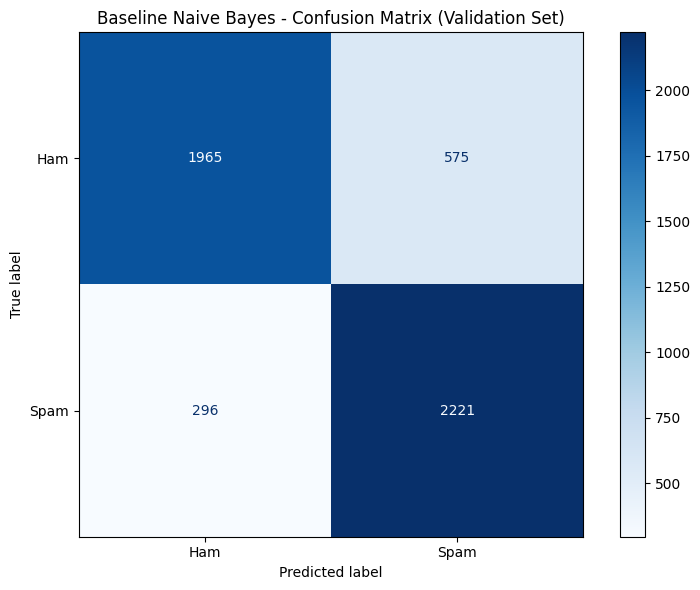


Confusion Matrix:
True Negatives (Ham):  1965
False Positives:       575 (Ham classified as Spam)
False Negatives:       296 (Spam classified as Ham)
True Positives (Spam): 2221


In [19]:
# 13. Visualize baseline confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Baseline Naive Bayes - Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:")
print(f"True Negatives (Ham):  {cm[0,0]}")
print(f"False Positives:       {cm[0,1]} (Ham classified as Spam)")
print(f"False Negatives:       {cm[1,0]} (Spam classified as Ham)")
print(f"True Positives (Spam): {cm[1,1]}")


### Hyperparameter Tuning with GridSearchCV

In [20]:
# 14. Hyperparameter tuning for Naive Bayes
# Define parameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid,
    cv=5,
    scoring='f1', # can optionally optimize for 'accuracy' or 'precision' or 'recall'
    verbose=1,
    n_jobs=-1
)

print("Starting grid search with 5-fold cross-validation...")
print(f"Parameter grid: {param_grid}")

start_time = time.time()
grid_search.fit(X_train_combined, y_train)
search_time = time.time() - start_time

print(f"\n✓ Grid search completed in {search_time:.2f} seconds")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

# Show all results
print(f"\nAll results:")
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score'))


Starting grid search with 5-fold cross-validation...
Parameter grid: {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
Fitting 5 folds for each of 8 candidates, totalling 40 fits

✓ Grid search completed in 2.27 seconds

Best parameters: {'alpha': 0.001}
Best cross-validation F1-score: 0.8762

All results:
   param_alpha  mean_test_score  std_test_score  rank_test_score
0        0.001         0.876231        0.003634                1
1        0.010         0.862568        0.003794                2
2        0.100         0.836235        0.003307                3
3        0.500         0.800186        0.003461                4
4        1.000         0.777123        0.005662                5
5        2.000         0.744285        0.004372                6
6        5.000         0.710212        0.006321                7
7       10.000         0.684058        0.006207                8


In [21]:
# 15. Evaluate tuned model on validation set
best_nb = grid_search.best_estimator_

# Predictions
y_val_pred_tuned = best_nb.predict(X_val_combined)
y_val_proba_tuned = best_nb.predict_proba(X_val_combined)[:, 1]

# Metrics
val_accuracy_tuned = accuracy_score(y_val, y_val_pred_tuned)
val_precision_tuned, val_recall_tuned, val_f1_tuned, _ = precision_recall_fscore_support(
    y_val, y_val_pred_tuned, average='binary'
)


print(f"Validation Performance (Tuned Model):")
print(f"Accuracy:  {val_accuracy_tuned:.4f} (baseline: {val_accuracy:.4f})")
print(f"Precision: {val_precision_tuned:.4f} (baseline: {val_precision:.4f})")
print(f"Recall:    {val_recall_tuned:.4f} (baseline: {val_recall:.4f})")
print(f"F1-Score:  {val_f1_tuned:.4f} (baseline: {val_f1:.4f})")

improvement = val_f1_tuned - val_f1
print(f"\nF1-Score improvement: {improvement:+.4f}")


Validation Performance (Tuned Model):
Accuracy:  0.8691 (baseline: 0.8278)
Precision: 0.8396 (baseline: 0.7943)
Recall:    0.9110 (baseline: 0.8824)
F1-Score:  0.8739 (baseline: 0.8361)

F1-Score improvement: +0.0378


### Final Evaluation on Test Set


In [22]:
# 16. Final test set evaluation
# Predictions on test set
start_time = time.time()
y_test_pred_nb = best_nb.predict(X_test_combined)
y_test_proba_nb = best_nb.predict_proba(X_test_combined)[:, 1]
inference_time = time.time() - start_time

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred_nb)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred_nb, average='binary'
)
test_auc = roc_auc_score(y_test, y_test_proba_nb)

print(f"Test Set Performance:")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"AUC-ROC:   {test_auc:.4f}")
print(f"\nInference time: {inference_time:.3f}s for {len(y_test)} samples")
print(f"Avg per sample: {inference_time/len(y_test)*1000:.2f}ms")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred_nb, target_names=['Ham', 'Spam']))


Test Set Performance:
Accuracy:  0.8693
Precision: 0.8469
Recall:    0.9093
F1-Score:  0.8770
AUC-ROC:   0.9437

Inference time: 0.018s for 5058 samples
Avg per sample: 0.00ms

Detailed Classification Report:
              precision    recall  f1-score   support

         Ham       0.90      0.83      0.86      2467
        Spam       0.85      0.91      0.88      2591

    accuracy                           0.87      5058
   macro avg       0.87      0.87      0.87      5058
weighted avg       0.87      0.87      0.87      5058



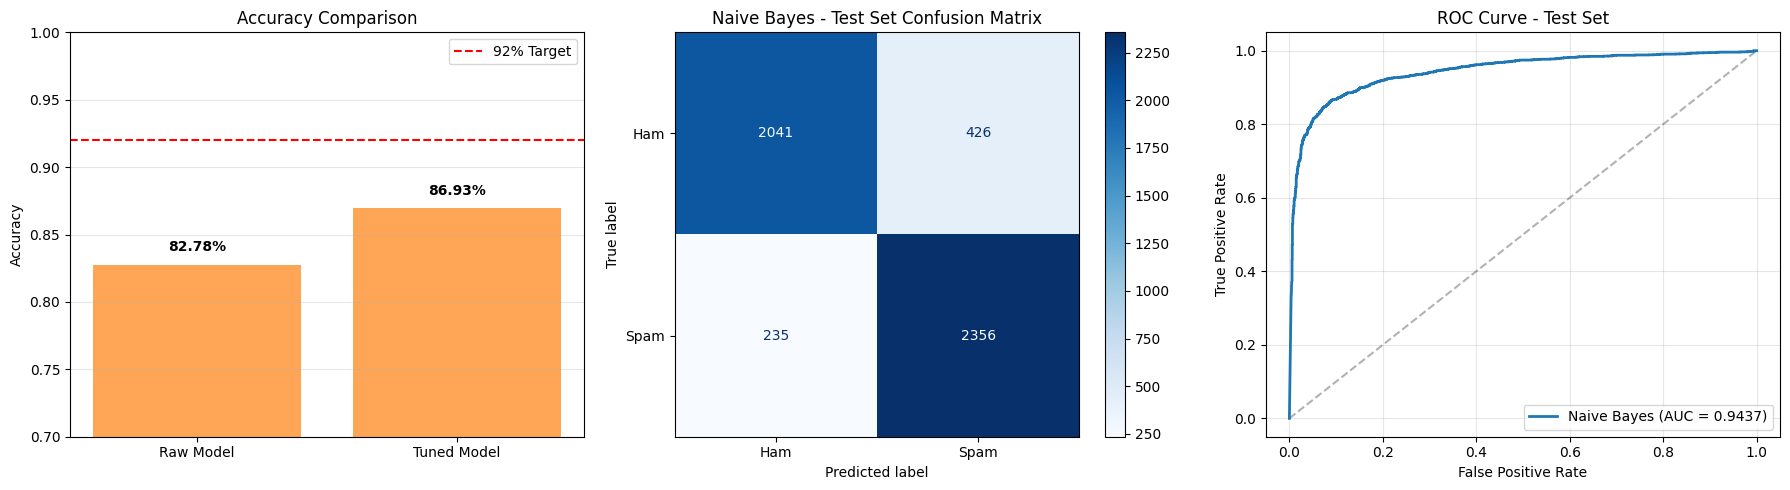


Test Set Confusion Matrix:
True Negatives (Ham):  2041
False Positives:       426 (Ham → Spam)
False Negatives:       235 (Spam → Ham)
True Positives (Spam): 2356


In [23]:
# 17. Visualize test set results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison:
models = ["Raw Model", "Tuned Model"]
accuracies = [val_accuracy, test_accuracy]
colors = ['#ff7f0e' if acc < 0.92 else '#2ca02c' for acc in accuracies]

axes[0].bar(models, accuracies, color=colors, alpha=0.7)
axes[0].axhline(y=0.92, color='r', linestyle='--', label='92% Target')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylim([0.7, 1.0])
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

for i, (model, acc) in enumerate(zip(models, accuracies)):
    axes[0].text(i, acc + 0.01, f'{acc*100:.2f}%', ha='center', fontweight='bold')

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues', ax=axes[1], values_format='d')
axes[1].set_title('Naive Bayes - Test Set Confusion Matrix')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_nb)
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[2].plot(fpr, tpr, label=f'Naive Bayes (AUC = {test_auc:.4f})', linewidth=2)
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve - Test Set')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTest Set Confusion Matrix:")
print(f"True Negatives (Ham):  {cm_test[0,0]}")
print(f"False Positives:       {cm_test[0,1]} (Ham → Spam)")
print(f"False Negatives:       {cm_test[1,0]} (Spam → Ham)")
print(f"True Positives (Spam): {cm_test[1,1]}")


### Feature Importance Analysis


In [24]:
# 18. Feature importance - top predictive features

# Get feature log probabilities
feature_names_all = list(tfidf_vectorizer.get_feature_names_out()) + numerical_features
log_prob_spam = best_nb.feature_log_prob_[1]  # Class 1 (spam)
log_prob_ham = best_nb.feature_log_prob_[0]   # Class 0 (ham)

# Calculate log-likelihood ratios
log_ratio = log_prob_spam - log_prob_ham

# Top spam indicators (high positive ratio)
top_spam_indices = np.argsort(log_ratio)[-25:][::-1]
print("\nTop 25 SPAM indicators:")
for idx in top_spam_indices:
    feature = feature_names_all[idx] if idx < len(feature_names_all) else f"feature_{idx}"
    print(f"  {feature:30s} (log-ratio: {log_ratio[idx]:.3f})")

# Top ham indicators (high negative ratio)
top_ham_indices = np.argsort(log_ratio)[:25]
print("\nTop 25 HAM indicators:")
for idx in top_ham_indices:
    feature = feature_names_all[idx] if idx < len(feature_names_all) else f"feature_{idx}"
    print(f"  {feature:30s} (log-ratio: {log_ratio[idx]:.3f})")



Top 25 SPAM indicators:
  viagra                         (log-ratio: 11.590)
  cialis                         (log-ratio: 11.216)
  pills                          (log-ratio: 11.127)
  pharmacy                       (log-ratio: 10.978)
  rolex                          (log-ratio: 10.957)
  utf                            (log-ratio: 10.803)
  andmanyother                   (log-ratio: 10.777)
  photoshop                      (log-ratio: 10.775)
  xanax                          (log-ratio: 10.702)
  paliourg                       (log-ratio: 10.701)
  valium                         (log-ratio: 10.604)
  adobe photoshop                (log-ratio: 10.522)
  corel                          (log-ratio: 10.503)
  vicodin                        (log-ratio: 10.497)
  to your door                   (log-ratio: 10.489)
  dose                           (log-ratio: 10.460)
  xp professional                (log-ratio: 10.460)
  mx 2004                        (log-ratio: 10.419)
  here to be         

# MODEL 2: TensorFlow Neural Network Classifier

Now we'll build a deep learning model using TensorFlow with dual inputs (text + numerical features).


In [25]:
# PRE-TRAINING DATA VERIFICATION - RUN THIS BEFORE TRAINING!
print("FINAL PRE-TRAINING DATA CHECK")
print("="*60)

# Verify the datasets are using cleaned data
sample_batch = next(iter(train_dataset))
sample_num = sample_batch[0]['numerical'].numpy()

print(f"✓ Sample batch numerical features:")
print(f"  Shape: {sample_num.shape}")
print(f"  Range: [{sample_num.min():.2f}, {sample_num.max():.2f}]")
print(f"  Mean: {sample_num.mean():.2f}")
print(f"  Std: {sample_num.std():.2f}")
print(f"  NaN count: {np.isnan(sample_num).sum()}")
print(f"  Inf count: {np.isinf(sample_num).sum()}")

if sample_num.max() > 10 or sample_num.min() < -10:
    print("\n⚠️  WARNING: Features not properly clipped!")
    print("   Please re-run Cell 16 (data splitting with clipping)")
    print("   Then re-run Cell 18 (dataset creation)")
elif np.isnan(sample_num).any() or np.isinf(sample_num).any():
    print("\n⚠️  WARNING: NaN or Inf values detected!")
    print("   Please re-run Cell 16 and Cell 18")
else:
    print("\n✅ Data looks good! Ready to train.")
    print("   Features are normalized and clipped properly.")


FINAL PRE-TRAINING DATA CHECK
✓ Sample batch numerical features:
  Shape: (32, 6)
  Range: [-1.23, 4.99]
  Mean: 0.03
  Std: 0.68
  NaN count: 0
  Inf count: 0

✅ Data looks good! Ready to train.
   Features are normalized and clipped properly.


In [26]:
# 19. Build baseline neural network architecture with NaN prevention
def build_nn_model(embed_dim=64, hidden_units=32, dropout_rate=0.3, learning_rate=0.0001):
    """Build dual-input neural network with MAXIMUM NaN prevention"""
    
    # Text input branch - SIMPLIFIED to prevent NaN
    text_input = Input(shape=(1,), dtype=tf.string, name='text')
    vectorized = vectorize_layer(text_input)
    
    # SMALLER embedding to prevent numerical instability
    embedded = Embedding(
        input_dim=MAX_VOCAB_SIZE, 
        output_dim=embed_dim,  # Use parameter, keep it small
        embeddings_initializer='glorot_uniform',
        mask_zero=False  # Disable masking - can cause NaN
    )(vectorized)
    pooled = GlobalAveragePooling1D()(embedded)
    
    # Numerical input branch
    # Data is already cleaned, scaled, and clipped in Cell 16
    num_input = Input(shape=(6,), name='numerical')
    num_dense = Dense(16, activation='relu', kernel_initializer='he_normal')(num_input)
    
    # Combine both branches
    combined = Concatenate()([pooled, num_dense])
    
    # SIMPLER hidden layers to prevent gradient explosion
    dense1 = Dense(hidden_units, activation='relu', kernel_initializer='he_normal')(combined)
    dropout1 = Dropout(dropout_rate)(dense1)
    
    # Output layer with stable initialization
    output = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(dropout1)
    
    # Create model
    model = Model(inputs={'text': text_input, 'numerical': num_input}, outputs=output)
    
    # Compile with VERY conservative settings
    optimizer = Adam(
        learning_rate=learning_rate,  # Very low learning rate
        clipnorm=1.0,  # Gradient clipping
        epsilon=1e-7  # Numerical stability
    )
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )
    
    return model

print("BUILDING STABLE NEURAL NETWORK")
print("="*60)
nn_baseline = build_nn_model(embed_dim=64, hidden_units=32, dropout_rate=0.3, learning_rate=0.00005)
print("\n✓ Model built with NaN prevention:")
print("  - Smaller architecture (64 embed, 32 hidden)")
print("  - mask_zero=False (masking can cause NaN)")
print("  - Data pre-cleaned in Cell 16 (scaled & clipped)")
print("  - Learning rate: 0.00005 (20x lower than default)")
print("  - Gradient clipping: clipnorm=1.0")
print("  - He/Glorot initialization for stability\n")
nn_baseline.summary()


BUILDING STABLE NEURAL NETWORK



✓ Model built with NaN prevention:
  - Smaller architecture (64 embed, 32 hidden)
  - mask_zero=False (masking can cause NaN)
  - Data pre-cleaned in Cell 16 (scaled & clipped)
  - Learning rate: 0.00005 (20x lower than default)
  - Gradient clipping: clipnorm=1.0
  - He/Glorot initialization for stability



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 200)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 64)   │    640,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical           │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ embedding[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        112 │ numerical[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,592 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 642,737 (2.45 MB)

 Trainable params: 642,737 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

## Train Baseline Neural Network


In [27]:
# 20. Train baseline neural network
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Train model
print("Training started...")
start_time = time.time()

history_baseline = nn_baseline.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)

train_time_nn = time.time() - start_time
print(f"\n✓ Training completed in {train_time_nn:.2f} seconds")


Training started...
Epoch 1/20


2025-12-28 21:12:56.063272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


738/738 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5793 - auc: 0.6171 - loss: 0.6786 - precision: 0.5789 - recall: 0.6620 - val_accuracy: 0.7471 - val_auc: 0.8324 - val_loss: 0.5794 - val_precision: 0.7019 - val_recall: 0.8550 - learning_rate: 5.0000e-05
Epoch 2/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7230 - auc: 0.7899 - loss: 0.5799 - precision: 0.7073 - recall: 0.7781 - val_accuracy: 0.8329 - val_auc: 0.9106 - val_loss: 0.4784 - val_precision: 0.8085 - val_recall: 0.8705 - learning_rate: 5.0000e-05
Epoch 3/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8068 - auc: 0.8831 - loss: 0.4788 - precision: 0.8073 - recall: 0.8206 - val_accuracy: 0.8930 - val_auc: 0.9527 - val_loss: 0.3862 - val_precision: 0.8871 - val_recall: 0.8995 - learning_rate: 5.0000e-05
Epoch 4/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8617 - auc: 0.9292 - loss: 0.3919 - precision: 0.8645 - recall: 0.8657 - val_accuracy: 0.9130 - val_auc: 0.9677 - val_loss: 0.3

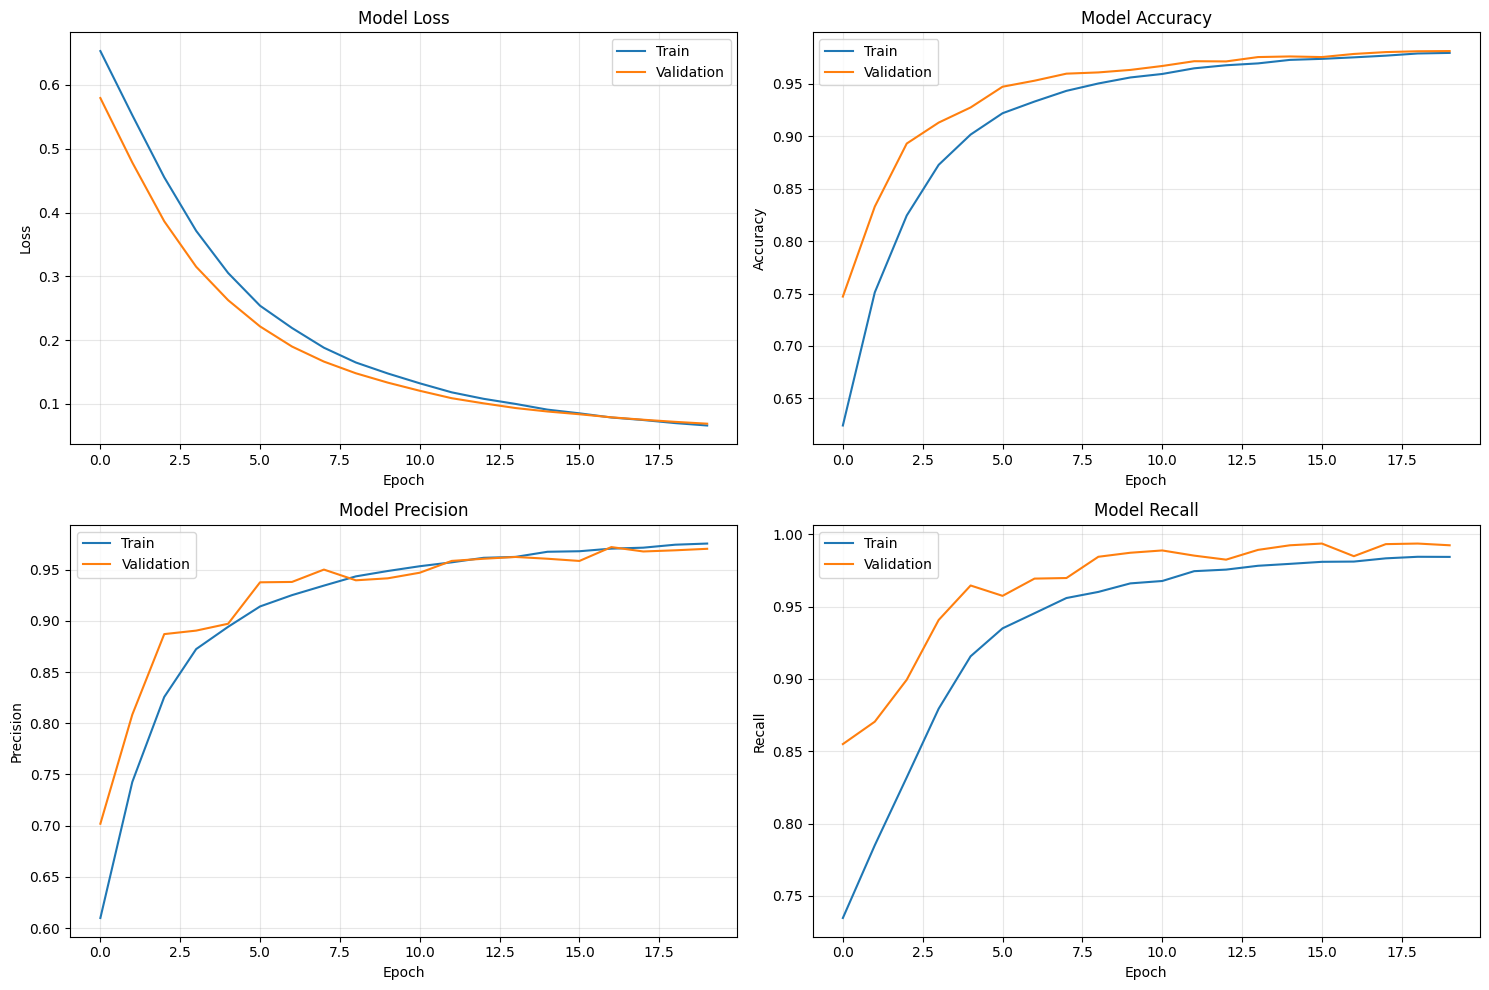


Final validation metrics:
Accuracy:  0.9812
Precision: 0.9705
Recall:    0.9925
AUC:       0.9963


In [28]:
# 21. Visualize training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history_baseline.history['loss'], label='Train')
axes[0, 0].plot(history_baseline.history['val_loss'], label='Validation')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history_baseline.history['accuracy'], label='Train')
axes[0, 1].plot(history_baseline.history['val_accuracy'], label='Validation')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history_baseline.history['precision'], label='Train')
axes[1, 0].plot(history_baseline.history['val_precision'], label='Validation')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history_baseline.history['recall'], label='Train')
axes[1, 1].plot(history_baseline.history['val_recall'], label='Validation')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal validation metrics:")
print(f"Accuracy:  {history_baseline.history['val_accuracy'][-1]:.4f}")
print(f"Precision: {history_baseline.history['val_precision'][-1]:.4f}")
print(f"Recall:    {history_baseline.history['val_recall'][-1]:.4f}")
print(f"AUC:       {history_baseline.history['val_auc'][-1]:.4f}")


## Hyperparameter Tuning with Optuna


In [29]:
# 22. Hyperparameter tuning with Optuna - Only use if accuracy is not good enough
def objective(trial):
    """Optuna objective function"""
    
    # Clear session to avoid memory issues
    tf.keras.backend.clear_session()
    
    # Suggest hyperparameters
    embed_dim = trial.suggest_categorical('embed_dim', [64, 128, 256])
    hidden_units = trial.suggest_categorical('hidden_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout', 0.3, 0.7)
    learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    
    # Build model with suggested hyperparameters
    model = build_nn_model(
        embed_dim=embed_dim,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )
    
    # Early stopping callback
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=15,
        callbacks=[lr_scheduler],
        verbose=0
    )
    
    # Return best validation F1 score (calculated from precision and recall)
    val_precision = max(history.history['val_precision'])
    val_recall = max(history.history['val_recall'])
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-7)
    
    return val_f1

# Create study and optimize
print("Starting Optuna optimization (20 trials)...")
print("This may take several minutes...\n")

study = optuna.create_study(direction='maximize', study_name='spam_nn_optimization')
study.optimize(objective, n_trials=10, show_progress_bar=True) # standard is 20

print(f"\n✓ Optimization completed!")
print(f"\nBest trial:")
print(f"  Value (F1): {study.best_value:.4f}")
print(f"  Parameters: {study.best_params}")


[I 2025-12-28 21:17:40,305] A new study created in memory with name: spam_nn_optimization


Starting Optuna optimization (20 trials)...
This may take several minutes...



  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/p6/zg0lyx5953dcs4vpkkf104_w0000gq/T/ipykernel_98026/81067475.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)


[I 2025-12-28 21:20:55,313] Trial 0 finished with value: 0.9959120268951794 and parameters: {'embed_dim': 64, 'hidden_units': 32, 'dropout': 0.3923331851637182, 'lr': 0.006156068245059924}. Best is trial 0 with value: 0.9959120268951794.
[I 2025-12-28 21:24:10,909] Trial 1 finished with value: 0.9945154294182597 and parameters: {'embed_dim': 64, 'hidden_units': 64, 'dropout': 0.5212957389334273, 'lr': 0.006500968950644913}. Best is trial 0 with value: 0.9959120268951794.
[I 2025-12-28 21:28:38,001] Trial 2 finished with value: 0.9954939024731668 and parameters: {'embed_dim': 256, 'hidden_units': 128, 'dropout': 0.43189175511834166, 'lr': 0.00036088736208664843}. Best is trial 0 with value: 0.9959120268951794.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00029920373344793916.
[I 2025-12-28 21:31:59,371] Trial 3 finished with value: 0.9943371211553346 and parameters: {'embed_dim': 64, 'hidden_units': 128, 'dropout': 0.41284441221744517, 'lr': 0.0005984074798079295}. Best is t


Top 5 trials:
   number     value  params_embed_dim  params_hidden_units  params_dropout  \
6       6  0.996330                64                   64        0.578760   
0       0  0.995912                64                   32        0.392333   
8       8  0.995726               256                   32        0.547282   
2       2  0.995494               256                  128        0.431892   
7       7  0.995291               256                  128        0.612482   

   params_lr  
6   0.001387  
0   0.006156  
8   0.002626  
2   0.000361  
7   0.000248  


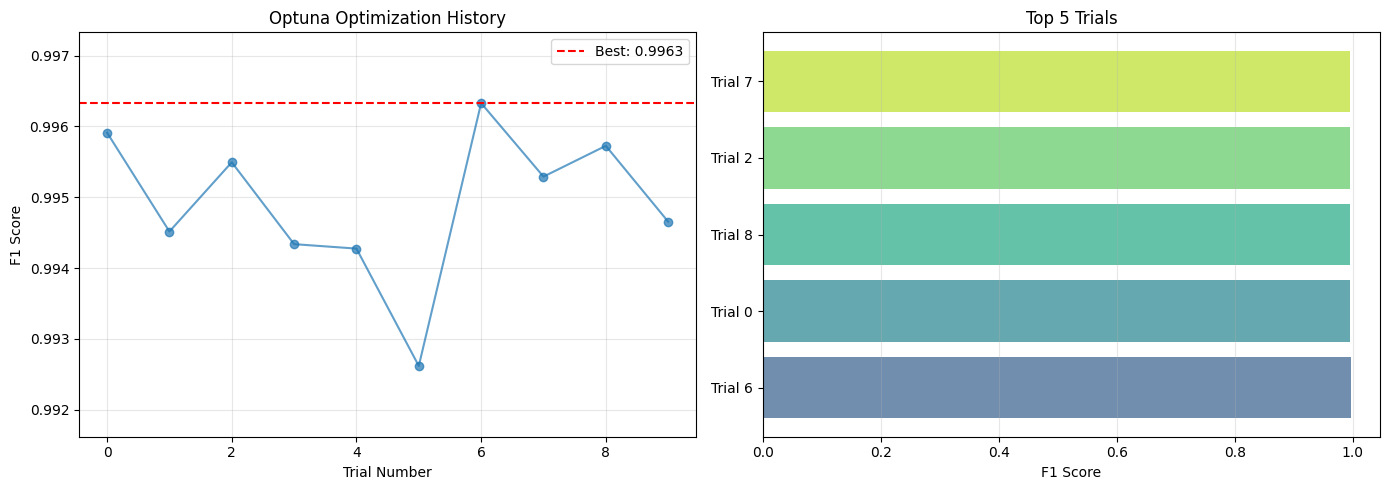


Best hyperparameters for final model:
  embed_dim: 64
  hidden_units: 64
  dropout: 0.57876045041715
  lr: 0.0013874858533780086


In [36]:
# 23. Visualize Optuna results

# Display trial results
trials_df = study.trials_dataframe()
print("\nTop 5 trials:")
print(trials_df.sort_values('value', ascending=False).head()[['number', 'value', 'params_embed_dim', 
                                                                 'params_hidden_units', 'params_dropout', 'params_lr']])

# Visualize optimization history with matplotlib
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot trial values over time
axes[0].plot(trials_df['number'], trials_df['value'], 'o-', alpha=0.7, color='#1f77b4')
axes[0].axhline(y=trials_df['value'].max(), color='r', linestyle='--', label=f'Best: {trials_df["value"].max():.4f}')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Optuna Optimization History')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_ylim([trials_df['value'].min() - 0.001, trials_df['value'].max() + 0.001])

# Plot parameter distribution for best trials
top_trials = trials_df.sort_values('value', ascending=False).head(5)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_trials)))
axes[1].barh(range(len(top_trials)), top_trials['value'], alpha=0.7, color=colors)
axes[1].set_yticks(range(len(top_trials)))
axes[1].set_yticklabels([f"Trial {n}" for n in top_trials['number']])
axes[1].set_xlabel('F1 Score')
axes[1].set_title('Top 5 Trials')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nBest hyperparameters for final model:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")


## Final Neural Network Evaluation


In [37]:
# 24. Train final model with best hyperparameters
# Clear session
tf.keras.backend.clear_session()

# Build model with best hyperparameters
best_nn = build_nn_model(
    embed_dim=study.best_params['embed_dim'],
    hidden_units=study.best_params['hidden_units'],
    dropout_rate=study.best_params['dropout'],
    learning_rate=study.best_params['lr']
)

print("Model architecture with optimized hyperparameters:")
best_nn.summary()

# Callbacks
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=7,
#     restore_best_weights=True,
#     verbose=1
# )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train
print("\nTraining final model...")
start_time = time.time()

history_final = best_nn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[reduce_lr],
    verbose=1
)

final_train_time = time.time() - start_time
print(f"\n✓ Final model trained in {final_train_time:.2f} seconds")


Model architecture with optimized hyperparameters:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 200)       │          0 │ text[0][0]        │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 64)   │    640,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical           │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ embedding[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        112 │ numerical[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      5,184 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 645,361 (2.46 MB)

 Trainable params: 645,361 (2.46 MB)

 Non-trainable params: 0 (0.00 B)


Training final model...
Epoch 1/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.7877 - auc: 0.8542 - loss: 0.4414 - precision: 0.7811 - recall: 0.8029 - val_accuracy: 0.9765 - val_auc: 0.9952 - val_loss: 0.0827 - val_precision: 0.9673 - val_recall: 0.9861 - learning_rate: 0.0014
Epoch 2/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.9686 - auc: 0.9939 - loss: 0.0917 - precision: 0.9646 - recall: 0.9741 - val_accuracy: 0.9587 - val_auc: 0.9971 - val_loss: 0.1136 - val_precision: 0.9246 - val_recall: 0.9984 - learning_rate: 0.0014
Epoch 3/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.9795 - auc: 0.9979 - loss: 0.0547 - precision: 0.9764 - recall: 0.9836 - val_accuracy: 0.9703 - val_auc: 0.9972 - val_loss: 0.0831 - val_precision: 0.9451 - val_recall: 0.9984 - learning_rate: 0.0014
Epoch 4/20
738/738 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.9835 - auc: 0.9985 - loss: 0.0441 - precision: 0.9826 - recall: 0.9851 - val_accuracy: 0.9871 - val_auc

In [38]:
# 25. Evaluate on test set
print("FINAL NEURAL NETWORK TEST PERFORMANCE")
print("="*60)

# Evaluate
start_time = time.time()
test_results = best_nn.evaluate(test_dataset, verbose=0)
nn_inference_time = time.time() - start_time

test_loss, test_acc, test_prec, test_rec, test_auc_nn = test_results

# Calculate F1
test_f1_nn = 2 * (test_prec * test_rec) / (test_prec + test_rec)

print(f"Test Set Performance:")
print(f"Loss:      {test_loss:.4f}")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-Score:  {test_f1_nn:.4f}")
print(f"AUC-ROC:   {test_auc_nn:.4f}")
print(f"\nInference time: {nn_inference_time:.3f}s for {len(y_test)} samples")
print(f"Avg per sample: {nn_inference_time/len(y_test)*1000:.2f}ms")

# Get predictions for confusion matrix
y_test_proba_nn = best_nn.predict(test_dataset, verbose=0)
y_test_pred_nn = (y_test_proba_nn > 0.5).astype(int).flatten()


FINAL NEURAL NETWORK TEST PERFORMANCE
Test Set Performance:
Loss:      0.0363
Accuracy:  0.9919
Precision: 0.9896
Recall:    0.9946
F1-Score:  0.9921
AUC-ROC:   0.9981

Inference time: 1.923s for 5058 samples
Avg per sample: 0.38ms


NEURAL NETWORK TEST VISUALIZATIONS


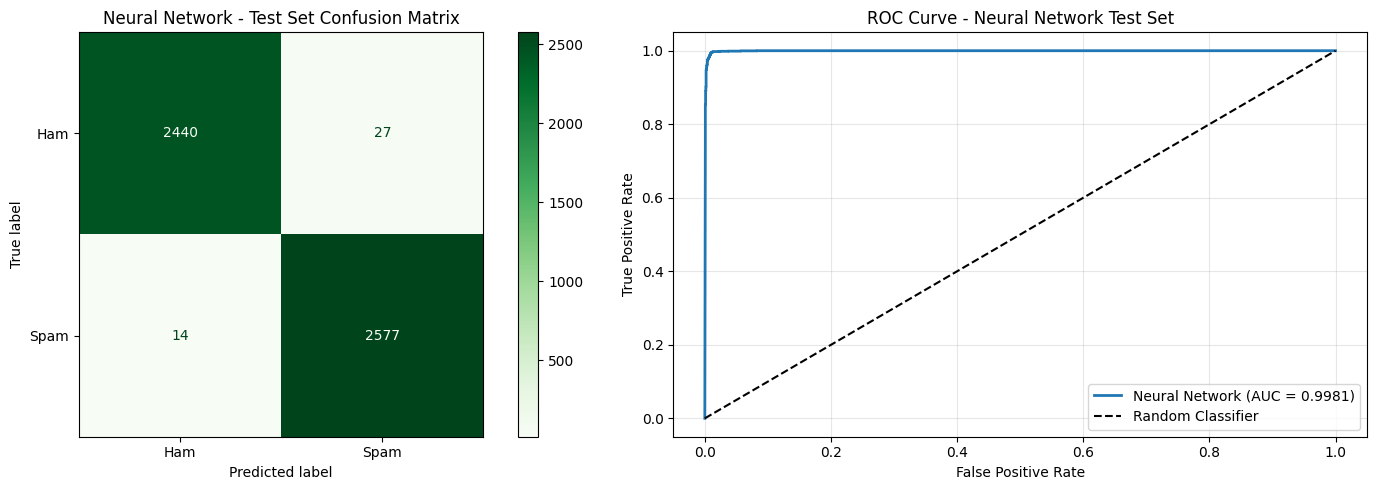


Test Set Confusion Matrix:
True Negatives (Ham):  2440
False Positives:       27 (Ham → Spam)
False Negatives:       14 (Spam → Ham)
True Positives (Spam): 2577


In [39]:
# 26. Visualize NN test results
print("NEURAL NETWORK TEST VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion matrix
cm_test_nn = confusion_matrix(y_test, y_test_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_nn, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Greens', ax=axes[0], values_format='d')
axes[0].set_title('Neural Network - Test Set Confusion Matrix')

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_test_proba_nn)
axes[1].plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {test_auc_nn:.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Neural Network Test Set')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTest Set Confusion Matrix:")
print(f"True Negatives (Ham):  {cm_test_nn[0,0]}")
print(f"False Positives:       {cm_test_nn[0,1]} (Ham → Spam)")
print(f"False Negatives:       {cm_test_nn[1,0]} (Spam → Ham)")
print(f"True Positives (Spam): {cm_test_nn[1,1]}")


# PART 3: Model Comparison & Analysis

Compare both approaches and determine which is best for spam detection.


In [40]:
# 27. Performance comparison table
print("MODEL COMPARISON - TEST SET RESULTS")
print("="*60)

# Create comparison dataframe
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 
               'Training Time (s)', 'Inference Time (s)'],
    'Naive Bayes': [
        test_accuracy,
        test_precision,
        test_recall,
        test_f1,
        test_auc,
        train_time + search_time,  # Including grid search time
        inference_time
    ],
    'Neural Network': [
        test_acc,
        test_prec,
        test_rec,
        test_f1_nn,
        test_auc_nn,
        final_train_time,
        nn_inference_time
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference (NN - NB)'] = comparison_df['Neural Network'] - comparison_df['Naive Bayes']

print("\n", comparison_df.to_string(index=False))

# Determine winner
if test_f1_nn > test_f1:
    winner = "Neural Network"
    margin = test_f1_nn - test_f1
else:
    winner = "Naive Bayes"
    margin = test_f1 - test_f1_nn

print(f"\n🏆 Winner: {winner} (F1 advantage: {margin:.4f})")


MODEL COMPARISON - TEST SET RESULTS

             Metric  Naive Bayes  Neural Network  Difference (NN - NB)
          Accuracy     0.869316        0.991894              0.122578
         Precision     0.846873        0.989631              0.142759
            Recall     0.909301        0.994597              0.085295
          F1-Score     0.876977        0.992108              0.115130
           AUC-ROC     0.943686        0.998121              0.054435
 Training Time (s)     2.436021      290.384842            287.948821
Inference Time (s)     0.017792        1.922810              1.905018

🏆 Winner: Neural Network (F1 advantage: 0.1151)
